This notebook implements the model where Attention network uses LSTM layers.</br>
Run all code cells sequentially

In [ ]:
!unzip NSE_Dataset.zip -d NSE_Dataset

In [2]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler


In [4]:
project_dir = ''
data_dir = 'NSE_Dataset'

In [5]:
#Primary input series (we aim to predict stock price of AXIS BANK)
df1 = pd.read_csv(data_dir + '/AXISBANK.csv')

#Secondary input series (we use these series to train the attention model)
df2 = pd.read_csv(data_dir + '/HDFCBANK.csv')  
df4 = pd.read_csv(data_dir + '/ICICIBANK.csv') 
df6 = pd.read_csv(data_dir + '/KOTAKBANK.csv') 
df8 = pd.read_csv(data_dir + '/INFY.csv')
df11 = pd.read_csv(data_dir + '/RELIANCE.csv')


Data Preprocessing

In [6]:
# Eliminate price changes due to Stock Splits and Bonus Issue

dates_axis = ['2014-07-28']
dates_hdfc = ['2011-07-14', '2019-09-19']
dates_icici = ['2014-12-04', '2017-06-20']
dates_kotak = ['2004-08-25', '2005-08-25', '2010-09-13', '2015-07-08']
dates_infy = ['2004-07-01', '2006-07-13', '2014-12-02', '2015-06-15', '2018-09-04']
dates_tsteel = ['2004-08-11']
dates_reliance = ['2009-11-26', '2017-09-07']
for df, price_split_dates in zip([df1, df2, df4, df6, df8, df11], \
                                 [dates_axis, dates_hdfc, dates_icici, dates_kotak, dates_infy, dates_reliance]):
  for dt in price_split_dates:
    diff = df.loc[df['Date'] == dt]['Prev Close'] - df.loc[df['Date'] == dt]['Open']
    for col in ['Prev Close', 'Open', 'Low', 'High', 'Close']:
      df.loc[df['Date'] >= dt, col] += float(diff)

#df2.loc[df1['Date'].isin(['2019-09-19'])]

In [7]:
def moving_avg(a, n):
  b = np.copy(a)
  for i in range(n, len(a)+1):
    b[i-1] = np.mean(a[i-n:i])
  return b

In [8]:
# MinMax Scaling with range [0-5]
moving_avg_n = 10
scalers = []
scaled_X = []
tot_seq_len = len(df1)
for i, df in enumerate([df1, df2, df4, df6, df8, df11]):
  scaler = MinMaxScaler(feature_range=(0, 5))
  scaled_X.append(moving_avg(np.reshape(np.array(df['Close']), (-1, 1)), moving_avg_n))
  scaled_X[i] = scaler.fit_transform(scaled_X[i])
  if len(df) < tot_seq_len:
    scaled_X[i] = np.concatenate((scaled_X[i][0:tot_seq_len-len(df)], scaled_X[i]))
  scalers.append(scaler)  

In [9]:
# Dataset formation

class Dataset(torch.utils.data.Dataset):
  def __init__(self, input_seqs, start, end, inp_len, oup_len):
    self.X = []
    self.y = []
    
    for seq in input_seqs:
      Xt = []
      yt = []
      for i in range(start+inp_len, end-oup_len):
        Xt.append(torch.Tensor(seq[i-inp_len:i]).to(device))
        yt.append(torch.Tensor(seq[i:i+oup_len]).to(device))
      self.X.append(np.array(Xt))
      self.y.append(np.array(yt))
    self.len = len(self.X[0])

  def __len__(self):
    return self.len

  def __getitem__(self, index):
    X = []
    y = []
    for i in range(len(self.X)):
      X.append(self.X[i][index])
      y.append(self.y[i][index])     
    return (X, y)

inp_len = 60
oup_len = 30 #10
n_companies = 6
lstm_hidden = 50

n_train = int(len(scaled_X[0])*0.8)
train_dataset = Dataset(scaled_X, 0, n_train+oup_len, inp_len, oup_len)
test_dataset = Dataset(scaled_X, n_train-inp_len, len(scaled_X[0]), inp_len, oup_len)

Model Implementation

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim

In [11]:
class AttentionLayer(nn.Module):
  def __init__(self, n_hidden, n_lstm_layers, n_outputs):  
    super(AttentionLayer, self).__init__()
    self.scores = []
    
    self.layer1 = nn.LSTM(input_size=1, hidden_size=n_hidden[0], num_layers=n_lstm_layers, batch_first=True, dropout=0.2).to(device)
    self.layer2 = nn.Sequential(nn.Linear(in_features=n_hidden[0], out_features=n_hidden[1], bias=True),
        nn.ReLU(inplace=False),
        nn.Linear(in_features=n_hidden[1], out_features=n_outputs, bias=True),
        nn.Softmax(dim=-1)
        )
    
  def forward(self, inputs): 
    [seq, val] = inputs
    
    x = torch.cat(seq, dim=1)  
    x=x.detach() 
    out, (h, c) = self.layer1(x.float())
    self.scores = self.layer2(h) 
    z=self.scores[2,:,0]
    z=torch.reshape(z, (1, -1, 1))
    output = z.repeat(1, 1, val[0].shape[2])*val[0].detach()
    for i in range(1, len(seq)):
      z=self.scores[2,:,i]
      z=torch.reshape(z, (1, -1, 1))
      output += z.repeat(1, 1, val[0].shape[2])*val[i].detach()

    return output

In [12]:
class LSTMModel(nn.Module):
  def __init__(self, lstm_units, n_companies, out_seq):
    super(LSTMModel, self).__init__()
    self.lstm_units = lstm_units
    self.n_companies = n_companies
    self.out_seq = out_seq #Length of final output sequene of the model

    self.lstm_1 = []
    self.lstm_2 = []
    self.lstm_3 = []
    self.dense = []
    self.weights = []

    for i in range(self.n_companies):
      self.lstm_1.append(nn.LSTM(input_size=1, hidden_size=self.lstm_units, num_layers=1, batch_first=True).to(device))#dropout=0.2, 
      self.lstm_2.append(nn.LSTM(input_size=self.lstm_units, hidden_size=self.lstm_units, num_layers=1, batch_first=True).to(device))#dropout=0.2, 
      self.lstm_3.append(nn.LSTM(input_size=self.lstm_units, hidden_size=self.lstm_units, num_layers=1, batch_first=True).to(device))#dropout=0.2, 
      self.dense.append(nn.Linear(in_features=self.lstm_units, out_features=self.out_seq, bias=True).to(device))
      self.weights.append([self.lstm_1[i].parameters(), self.lstm_2[i].parameters(), \
                           self.lstm_3[i].parameters(), self.dense[i].parameters()])

  def forward(self, inputs):
    lstm1_seq = []
    lstm1_hn = []
    for i in range(self.n_companies):
      out, (h, c) = self.lstm_1[i](inputs[i].float())
      lstm1_seq.append(out)
      lstm1_hn.append(torch.squeeze(h, dim=0))

    lstm2_seq = []
    lstm2_hn = []
    
    for i in range(0, self.n_companies):
      out, (h, c) = self.lstm_2[i](lstm1_seq[i])
      lstm2_seq.append(out)
      lstm2_hn.append(torch.squeeze(h, dim=0))
    
    lstm3_seq = []
    lstm3_hn = []
    
    for i in range(0, self.n_companies):
      out, (h, c) = self.lstm_3[i](lstm2_seq[i])
      lstm3_seq.append(out)
      lstm3_hn.append(h)
    out = []  
    for i in range(0, self.n_companies):
      out.append(self.dense[i](lstm3_hn[i]))
    
    return out

In [13]:
 np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

Model Training

In [14]:
# Training loop
batch_size = 128 
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)

epochs = 150
epoch_start = 0
lr = 0.0005
pred_model = LSTMModel(lstm_units=lstm_hidden, n_companies=n_companies, out_seq=oup_len)
pred_model.to(device)

optimizers = []
losses_fn = []
for pw in pred_model.weights:
  w = [item for sublist in pw for item in sublist]
  optimizers.append(optim.Adam(w, lr))
  losses_fn.append(nn.MSELoss())


attention1 = AttentionLayer(n_hidden = [100, 50], n_lstm_layers=3, n_outputs=n_companies)
attention1.to(device)
att_optim = optim.Adam(attention1.parameters(), lr)
att_loss_fn = nn.MSELoss()

lstm_loss2 = []
att_loss2 = []

for epoch in range(epoch_start, epochs):
  lstm_loss = []
  att_loss = []
  for j in range(n_companies):
    lstm_loss.append([])
  for i, data in enumerate(train_loader):
    X, y = data    
    out = pred_model(X)
    for j, pred in enumerate(out):
      optimizers[j].zero_grad()
      pred = torch.unsqueeze(torch.squeeze(pred, dim=0), dim=2)
      l = losses_fn[j](pred, y[j].float())
      l.backward()
      optimizers[j].step()
      lstm_loss[j].append(l)
    
    att_optim.zero_grad()
    att_out = attention1([X, out])    
   # print(att_out.shape, y[0].shape)
    att_l = att_loss_fn(torch.squeeze(att_out, dim=0), torch.squeeze(y[0], dim=2))
    att_l.backward()
    att_optim.step()
    att_loss.append(att_l)

  ll = []
  for k in lstm_loss:
    ll.append(torch.mean(torch.Tensor(k).to(device)))
  lstm_loss2.append([ll[0], ll[1], ll[2], ll[3], ll[4], ll[5]])
  al = torch.mean(torch.Tensor(att_loss).to(device))
  att_loss2.append(al)
  
  print(attention1.scores[0][0].detach().cpu().numpy())
  print('%d/%d %d \tl1: %.3f \tl2: %.3f \tl3: %.3f \t14: %.3f \tl5: %.3f \tl5: %.3f \tatt_l: %.3f'%(epoch, epochs, i, \
    ll[0], ll[1], ll[2], ll[3], ll[4], ll[5], al))
  

[0.175 0.157 0.155 0.153 0.183 0.178]
0/150 31 	l1: 4.313 	l2: 3.506 	l3: 4.444 	14: 2.996 	l5: 2.996 	l5: 2.745 	att_l: 4.342
[0.182 0.150 0.186 0.129 0.186 0.168]
1/150 31 	l1: 2.245 	l2: 1.639 	l3: 1.919 	14: 0.994 	l5: 0.767 	l5: 1.142 	att_l: 1.918
[0.189 0.148 0.183 0.133 0.182 0.164]
2/150 31 	l1: 2.166 	l2: 1.657 	l3: 1.770 	14: 1.269 	l5: 0.569 	l5: 1.110 	att_l: 2.208
[0.196 0.146 0.180 0.132 0.181 0.165]
3/150 31 	l1: 1.770 	l2: 1.563 	l3: 1.788 	14: 1.190 	l5: 0.552 	l5: 0.992 	att_l: 2.165
[0.215 0.145 0.179 0.119 0.173 0.169]
4/150 31 	l1: 0.869 	l2: 0.889 	l3: 1.748 	14: 0.993 	l5: 0.532 	l5: 0.452 	att_l: 1.423
[0.219 0.144 0.185 0.116 0.166 0.170]
5/150 31 	l1: 0.650 	l2: 0.429 	l3: 1.425 	14: 0.482 	l5: 0.526 	l5: 0.132 	att_l: 0.705
[0.218 0.145 0.187 0.115 0.165 0.170]
6/150 31 	l1: 0.454 	l2: 0.188 	l3: 0.699 	14: 0.324 	l5: 0.518 	l5: 0.149 	att_l: 0.466
[0.217 0.145 0.188 0.115 0.165 0.170]
7/150 31 	l1: 0.410 	l2: 0.149 	l3: 0.533 	14: 0.313 	l5: 0.497 	l5: 0.08

In [15]:
t1 = []
t2 = []
t3 = []
t4 = []
t5 = []
t6 = []
for i, data in enumerate(lstm_loss2):
  l1, l2, l3, l4, l5, l6= data
  t1.append(l1)
  t2.append(l2)
  t3.append(l3)
  t4.append(l4)
  t5.append(l5)
  t6.append(l6)

In [16]:
print("Training Error")
print(torch.mean(torch.Tensor(t1)))
print(torch.mean(torch.Tensor(t2)))
print(torch.mean(torch.Tensor(t3)))
print(torch.mean(torch.Tensor(t4)))
print(torch.mean(torch.Tensor(t5)))
print(torch.mean(torch.Tensor(t6)))

Training Error
tensor(0.1239)
tensor(0.0946)
tensor(0.1471)
tensor(0.0784)
tensor(0.0750)
tensor(0.0691)


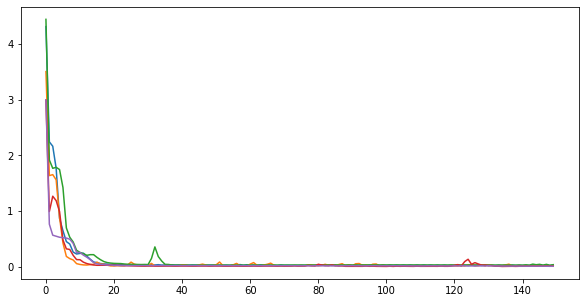

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(t1)
plt.plot(t2)
plt.plot(t3)
plt.plot(t4)
plt.plot(t5)

Model Inference (running on test data)

In [19]:
# Inference

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

test_loss = [[], [], [], [], [], [], []]
test_outs = [[], [], [], [], [], []]
for i, data in enumerate(test_loader):
  #tr_loss = []
  X, y = data
  with torch.no_grad():
    out = pred_model(X)
    for j, pred in enumerate(out):
      pred = torch.unsqueeze(torch.squeeze(pred, dim=0), dim=2)
      l = losses_fn[j](pred, y[j].float())
      test_loss[j].append(l)
      test_outs[j].append(pred)
    att_out = attention1([X, out])    
    att_l = att_loss_fn(torch.squeeze(att_out, dim=0), torch.squeeze(y[0], dim=2))
    test_loss[-1].append(att_l)
    print('%d \tl1: %.3f \tl2: %.3f \tl3: %.3f \t14: %.3f \tl5: %.3f \tl6: %.3f \tatt_l: %.3f'%(i, \
                  test_loss[0][i], test_loss[1][i], test_loss[2][i], test_loss[3][i], \
                  test_loss[4][i], test_loss[5][i], test_loss[6][i]))


0 	l1: 0.002 	l2: 0.002 	l3: 0.015 	14: 0.003 	l5: 0.001 	l6: 0.024 	att_l: 0.012
1 	l1: 0.003 	l2: 0.002 	l3: 0.015 	14: 0.003 	l5: 0.001 	l6: 0.025 	att_l: 0.012
2 	l1: 0.003 	l2: 0.001 	l3: 0.015 	14: 0.004 	l5: 0.001 	l6: 0.026 	att_l: 0.014
3 	l1: 0.004 	l2: 0.001 	l3: 0.015 	14: 0.004 	l5: 0.001 	l6: 0.026 	att_l: 0.015
4 	l1: 0.004 	l2: 0.001 	l3: 0.015 	14: 0.005 	l5: 0.001 	l6: 0.027 	att_l: 0.016
5 	l1: 0.005 	l2: 0.001 	l3: 0.014 	14: 0.005 	l5: 0.001 	l6: 0.027 	att_l: 0.017
6 	l1: 0.005 	l2: 0.001 	l3: 0.013 	14: 0.005 	l5: 0.001 	l6: 0.028 	att_l: 0.018
7 	l1: 0.006 	l2: 0.001 	l3: 0.012 	14: 0.006 	l5: 0.001 	l6: 0.029 	att_l: 0.019
8 	l1: 0.006 	l2: 0.001 	l3: 0.011 	14: 0.006 	l5: 0.001 	l6: 0.030 	att_l: 0.020
9 	l1: 0.006 	l2: 0.001 	l3: 0.010 	14: 0.007 	l5: 0.002 	l6: 0.031 	att_l: 0.020
10 	l1: 0.006 	l2: 0.001 	l3: 0.009 	14: 0.007 	l5: 0.002 	l6: 0.033 	att_l: 0.020
11 	l1: 0.006 	l2: 0.002 	l3: 0.008 	14: 0.007 	l5: 0.002 	l6: 0.034 	att_l: 0.020
12 	l1: 0.006 

In [20]:
print("Testing Error")
print(torch.mean(torch.Tensor(test_loss[0])))
print(torch.mean(torch.Tensor(test_loss[1])))
print(torch.mean(torch.Tensor(test_loss[2])))
print(torch.mean(torch.Tensor(test_loss[3])))
print(torch.mean(torch.Tensor(test_loss[4])))
print(torch.mean(torch.Tensor(test_loss[5])))


Testing Error
tensor(0.0322)
tensor(0.3762)
tensor(0.0246)
tensor(0.5126)
tensor(0.0025)
tensor(0.3941)


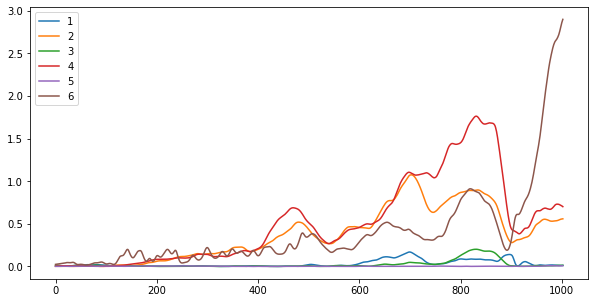

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(test_loss[0], label='1')
plt.plot(test_loss[1], label='2')
plt.plot(test_loss[2], label='3')
plt.plot(test_loss[3], label='4')
plt.plot(test_loss[4], label='5')
plt.plot(test_loss[5], label='6')
plt.legend(loc='upper left')

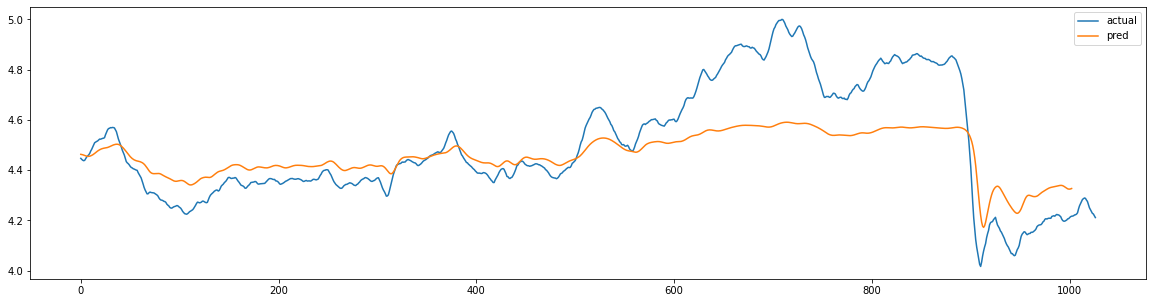

In [22]:
# View prediction and actual test series for primary series test data (AXIS Bank)

p = 0
X_train = scaled_X[p][:n_train]
y_actual = scaled_X[p][n_train:len(scaled_X[p])-n_companies]
y_pred = []
for o in test_outs[p]:
  y_pred.append(o[0][0])
plt.figure(figsize=(20, 5))
#plt.plot(y_actual[:oup_len*3], label='actual')
#plt.plot(torch.squeeze(test_outs[p][0]).cpu(), label='pred')

plt.plot(y_actual, label='actual')
plt.plot(y_pred, label='pred')
plt.legend(loc='upper right')

In [23]:
#Save Loss lists

import pickle as pkl

with open('LSTM_1Att_v3.pkl', 'wb') as f:
  obj = (lstm_loss2, att_loss2, test_loss, test_outs)
  pkl.dump(obj, f, pkl.HIGHEST_PROTOCOL)

In [ ]:
with open('LSTM_1Att_v3.pkl', 'rb') as f:
  obj = pkl.load(f)
a1, a2, a3, a4 = obj
a2